<a href="https://colab.research.google.com/github/GuillermoSainz07/Notebooks-DS/blob/main/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stock Price Prediction

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

### Preparacion de datos para modelo de prediccion
- El target value sera la GOOGL
- Utilizaremos los retornos por las propiedades estadisticas encontradas en la literatura economica-financiera
- Utilizaremos los valores de 2 acciones tecnologicas, aqui hay que tener cuidado de no filtrar informacion del futuro, para eso utilizaremos un retraso de 1 dia para esas acciones
- Utilizaremos el valor actual de la accion, decir un retraso de 1, para predecir los valores futuros
- Utilizamos retrasos semanales (5 dias), mensuales(20 dias) y de un ano (252 dias)
- Utilizamos el ano, dia, dia semanal y otros datos de fechas
- Agregaremos variables moviles como la media semanal y la volatilidad diaria, con el proposito que pueda capturar la tendencia y la volatildad a corto plazo
- En este caso solo probaremos 2 algoritmos XGB y XGB, sin optimizar parametros y sin validacion cruzada

In [ ]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']

stk_data = yf.download(start='2010-01-01',tickers= stk_tickers)['Adj Close']


[*********************100%%**********************]  3 of 3 completed


In [ ]:
stk_data

,GOOGL,IBM,MSFT
Date,,,
2010-01-04,15.684434,78.345856,23.522566
2010-01-05,15.615365,77.399475,23.530167
2010-01-06,15.221722,76.896667,23.385765
2010-01-07,14.867367,76.630478,23.142553
2010-01-08,15.065566,77.399475,23.302164
...,...,...,...
2023-09-18,138.210007,145.089996,329.059998
2023-09-19,138.039993,146.520004,328.649994
2023-09-20,133.740005,149.830002,320.769989


In [ ]:
retornos = (np.log(stk_data) -  np.log(stk_data).shift(1)).dropna()

<Axes: xlabel='Date'>

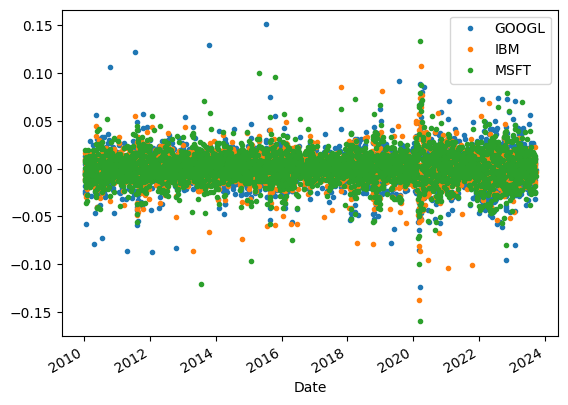

In [ ]:
retornos.plot(style='.')

### Definir el horizonte de pronostico

El horizonte de pronostico esta definido el la caracteristica con menor trasado. Es decir si nuestra caracteristica con menos retrasdo es de 1 ano, estamos topado a predecir hasta un ano solamente

### Creacion de caracteristicas para el modelo

#### Carateristicas de tiempo

In [ ]:
def create_features(df):
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

In [ ]:
df = retornos.copy()
df = create_features(df)
df

,GOOGL,IBM,MSFT,dayofweek,quarter,year,month,dayofyear,dayofmonth
Date,,,,,,,,,
2010-01-05,-0.004413,-0.012153,0.000323,1,1,2010,1,5,5
2010-01-06,-0.025532,-0.006517,-0.006156,2,1,2010,1,6,6
2010-01-07,-0.023555,-0.003468,-0.010454,3,1,2010,1,7,7
2010-01-08,0.013243,0.009985,0.006873,4,1,2010,1,8,8
2010-01-11,-0.001513,-0.010525,-0.012802,0,1,2010,1,11,11
...,...,...,...,...,...,...,...,...,...
2023-09-18,0.005878,-0.006184,-0.003519,0,3,2023,9,261,18
2023-09-19,-0.001231,0.009808,-0.001247,1,3,2023,9,262,19
2023-09-20,-0.031646,0.022339,-0.024269,2,3,2023,9,263,20


#### Caracteristicas de retraso

No usaremos `Timedelta` debido al que el mercado de valores no es continuo, si no que hay saltos en el tiempo en los fines de semana.

In [ ]:
target_map = retornos['GOOGL']

In [ ]:
def add_lags_stocks(df):
    df['lag1'] = target_map.shift(1)
    df['lag2'] = target_map.shift(5)
    df['lag3'] = target_map.shift(20)
    df['lag4'] = target_map.shift(252)
    df['IBM'] = df['IBM'].shift(1)
    df['MSFT'] = df['MSFT'].shift(1)
    return df

In [ ]:
def add_window(df):
    df['mean_window'] = target_map.rolling(window=5).mean()
    df['vol_window'] = target_map.rolling(window=2).std()

    return df

In [ ]:
df = add_lags_stocks(df)

In [ ]:
df = add_window(df)

In [ ]:
df

,GOOGL,IBM,MSFT,dayofweek,quarter,year,month,dayofyear,dayofmonth,lag1,lag2,lag3,lag4,mean_window,vol_window
Date,,,,,,,,,,,,,,,
2010-01-05,-0.004413,NaN,NaN,1,1,2010,1,5,5,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,-0.025532,-0.012153,0.000323,2,1,2010,1,6,6,-0.004413,NaN,NaN,NaN,NaN,0.014933
2010-01-07,-0.023555,-0.006517,-0.006156,3,1,2010,1,7,7,-0.025532,NaN,NaN,NaN,NaN,0.001398
2010-01-08,0.013243,-0.003468,-0.010454,4,1,2010,1,8,8,-0.023555,NaN,NaN,NaN,NaN,0.026020
2010-01-11,-0.001513,0.009985,0.006873,0,1,2010,1,11,11,0.013243,NaN,NaN,NaN,-0.008354,0.010434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18,0.005878,-0.009273,-0.025356,0,3,2023,9,261,18,-0.005082,0.003952,-0.019116,-0.020105,0.001876,0.007750
2023-09-19,-0.001231,-0.006184,-0.003519,1,3,2023,9,262,19,0.005878,-0.011607,0.007114,-0.001069,0.003951,0.005027
2023-09-20,-0.031646,0.009808,-0.001247,2,3,2023,9,263,20,-0.001231,0.010072,0.005516,0.002623,-0.004393,0.021507


In [ ]:
data = df.copy().dropna()

In [ ]:
x_train = data.iloc[:-252].drop('GOOGL', axis=1)
x_test = data.iloc[-252:].drop('GOOGL', axis=1)

y_train = data.iloc[:-252][['GOOGL']]
y_test = data.iloc[-252:][['GOOGL']]


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
gbmodel_05 = GradientBoostingRegressor(loss='quantile', alpha=0.05)
gbmodel_50 = GradientBoostingRegressor(loss='quantile', alpha=0.50)
gbmodel_95 = GradientBoostingRegressor(loss='quantile', alpha=0.95)

In [ ]:
xgbmodel = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 50,
                       learning_rate=0.01)
xgbmodel.fit(x_train, y_train,
        eval_set = [(x_train, y_train), (x_test,y_test)],
        verbose=100)

[0]	validation_0-rmse:0.49465	validation_1-rmse:0.49439
[100]	validation_0-rmse:0.18175	validation_1-rmse:0.18167
[200]	validation_0-rmse:0.06781	validation_1-rmse:0.06915
[300]	validation_0-rmse:0.02679	validation_1-rmse:0.03069
[400]	validation_0-rmse:0.01323	validation_1-rmse:0.02002
[500]	validation_0-rmse:0.00972	validation_1-rmse:0.01785
[600]	validation_0-rmse:0.00860	validation_1-rmse:0.01716
[700]	validation_0-rmse:0.00782	validation_1-rmse:0.01684
[800]	validation_0-rmse:0.00721	validation_1-rmse:0.01668
[876]	validation_0-rmse:0.00687	validation_1-rmse:0.01668


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
gbmodel_05.fit(x_train,y_train)
gbmodel_95.fit(x_train,y_train)
gbmodel_50.fit(x_train,y_train)

C:\Users\W10 2023\Documents\Python Scripts\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\W10 2023\Documents\Python Scripts\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\W10 2023\Documents\Python Scripts\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.5, loss='quantile')

In [ ]:
predicciones_05  = pd.DataFrame(gbmodel_05.predict(x_test),
                            index=y_test.index)

predicciones_95  = pd.DataFrame(gbmodel_95.predict(x_test),
                            index=y_test.index)

predicciones_50  = pd.DataFrame(gbmodel_50.predict(x_test),
                            index=y_test.index)

predicciones_mean = pd.DataFrame(xgbmodel.predict(x_test),
                            index=y_test.index)

In [ ]:
plt.style.use('dark_background')

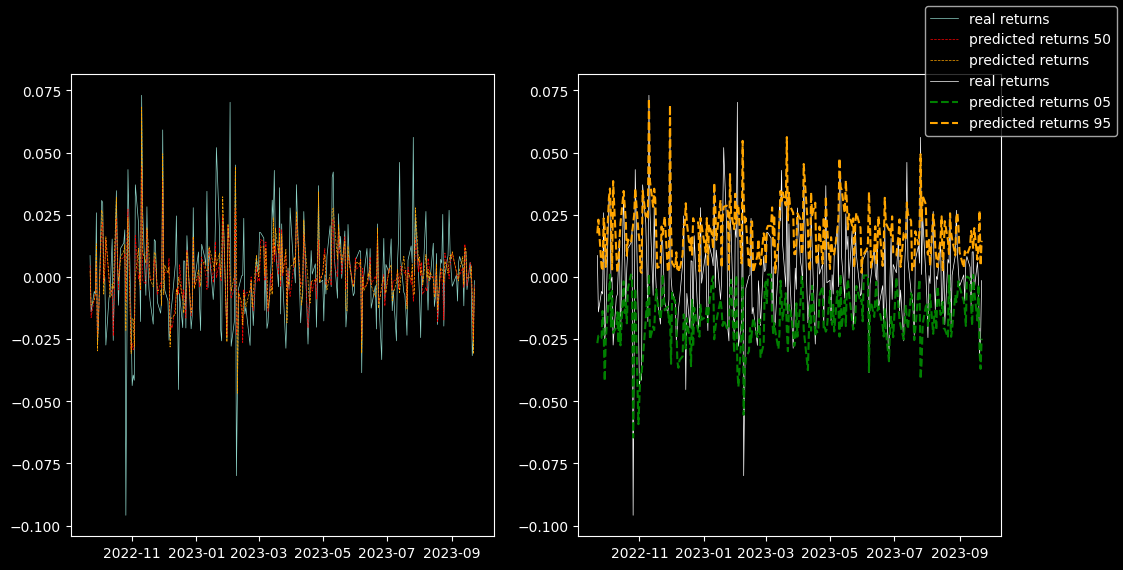

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(y_test,lw=0.5, label='real returns')
ax[0].plot(predicciones_50, ls='--', color='red', lw=0.5, label='predicted returns 50')
ax[0].plot(predicciones_mean, ls='--', color='orange', lw=0.5, label='predicted returns')


ax[1].plot(y_test,lw=0.5, label='real returns', color='white')
ax[1].plot(predicciones_05, ls='--', color='green', label='predicted returns 05')
ax[1].plot(predicciones_95, ls='--', color='orange', label='predicted returns 95')

fig.legend()
plt.show()

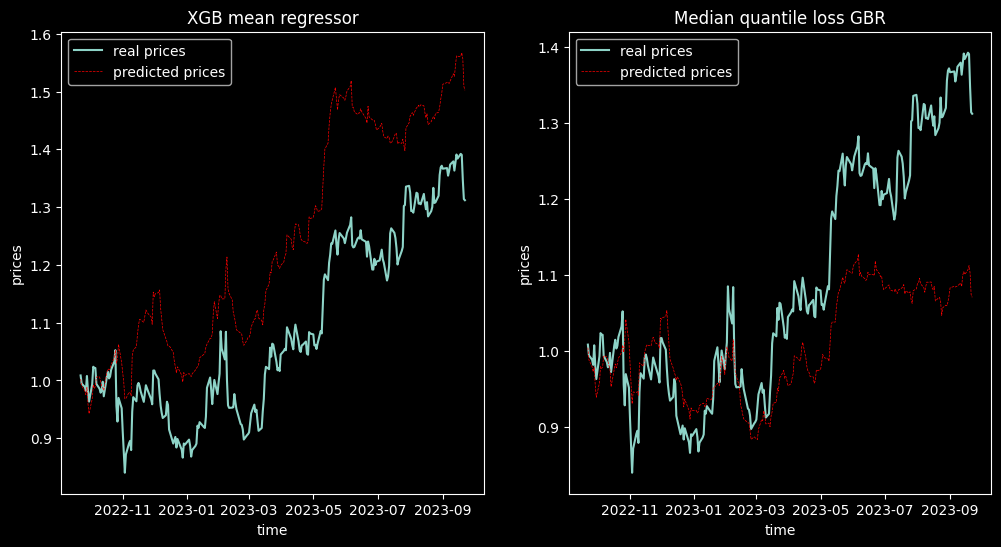

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(np.exp(y_test).cumprod(), label='real prices')
ax[0].plot(np.exp(predicciones_mean).cumprod(), ls='--', lw=0.5, color='red', label='predicted prices')
ax[0].legend()
ax[0].set_title('XGB mean regressor')
ax[0].set_xlabel('time')
ax[0].set_ylabel('prices')


ax[1].plot(np.exp(y_test).cumprod(), label='real prices')
ax[1].plot(np.exp(predicciones_50).cumprod(), ls='--', lw=0.5, color='red', label='predicted prices')
ax[1].legend()
ax[1].set_title('Median quantile loss GBR')
ax[1].set_xlabel('time')
ax[1].set_ylabel('prices')

plt.show()

### Observaciones finales

- Utilizamos los retornos para predecir los precios ya que los suspuestos estadisticos que la teoria economica y financiera con respecto a los retornos nos benefician
- Podemos observar que XGB captura de mejor manera la varianza o la volatilidad de nuestros datos, aun que sobre estima la tendencia.
- En cuanto a la regresion a la media por parte de GBR al inicio captura bien la volatilidad, pero luego subestima la tendencia del precio de las acciones.
- NO hicimos ningun tipo de optimizacion de parametros, a excepcion de earling stopping que es posible ajustar en XBG sin mayor esfuerzo
- Seria interesante utilzar quantile regression combinado con conformal prediction (conformalized quantile regression) para tratar de estimar otras metricas de riesgo como los VaR's con una medida de incertidumbre